In [1]:
import os,sys

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

from irf import irf_utils
from irf.ensemble import RandomForestClassifierWithWeights

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../data/exT.csv",low_memory=False, nrows = 5000)
print(df.shape)
df.head()

(5000, 19103)


,Unnamed: 0,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,SLCO4C1,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4
0,Liver.1,2.367912,0.698684,3.931116,0.000000,116.288461,13.839265,0.021383,14.722173,5.437620,...,0.000000,1.199607,0.101155,1.428458,2.471339,0.042357,44.610061,6.394772,0.281878,0.0
1,Kidney.1,26.299800,2.498500,0.255600,14.944300,2.049600,3.262300,0.146400,14.132900,3.323600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Prostate.1,5.592506,2.953563,7.065690,0.012499,325.521932,22.144552,0.356845,28.899361,6.717593,...,0.030674,2.062158,0.185503,8.414909,2.690346,0.688731,0.260365,9.792451,1.671371,0.0
3,Kidney.2,21.554200,1.334700,1.095300,23.476800,8.741300,11.491700,0.945500,32.975700,6.187900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Kidney.3,22.820100,2.640900,3.750800,29.774900,7.595200,15.186900,0.482000,19.233800,8.741800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [3]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 19103 entries, Unnamed: 0 to OR8D4
dtypes: float64(19099), int64(3), object(1)
memory usage: 728.7+ MB


In [4]:
df = df.rename(columns={'Unnamed: 0':'labels'})
df.head()

,labels,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,SLCO4C1,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4
0,Liver.1,2.367912,0.698684,3.931116,0.000000,116.288461,13.839265,0.021383,14.722173,5.437620,...,0.000000,1.199607,0.101155,1.428458,2.471339,0.042357,44.610061,6.394772,0.281878,0.0
1,Kidney.1,26.299800,2.498500,0.255600,14.944300,2.049600,3.262300,0.146400,14.132900,3.323600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Prostate.1,5.592506,2.953563,7.065690,0.012499,325.521932,22.144552,0.356845,28.899361,6.717593,...,0.030674,2.062158,0.185503,8.414909,2.690346,0.688731,0.260365,9.792451,1.671371,0.0
3,Kidney.2,21.554200,1.334700,1.095300,23.476800,8.741300,11.491700,0.945500,32.975700,6.187900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Kidney.3,22.820100,2.640900,3.750800,29.774900,7.595200,15.186900,0.482000,19.233800,8.741800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
# df.describe() # not so helpful because of 19k features

## FPKM Load

In [7]:
fpkm_df = pd.read_csv("../data/FPKM_gene_counts_FPKM.csv")
fpkm_df.head()

,Unnamed: 0,D0 Rep1,D0 Rep2,D0 Rep3,Unnamed: 4,D7 Rep1,D7 Rep2,D7 Rep3,Unnamed: 8,D13 Rep1,D13 Rep2,D13 Rep3,Unnamed: 12,D18 Rep1,D18 Rep2,D18 Rep3,Unnamed: 16,D28 Rep1,D28 Rep2,D28 Rep3
0,gene-MIR6859-1,0.000000,1.638304,0.000000,NaN,1.909625,3.125239,7.916809,NaN,0.000000,5.476164,0.000000,NaN,4.312032,0.000000,2.429304,NaN,0.000000,0.000000,0.000000
1,gene-LOC100996442,0.107611,0.066212,0.061441,NaN,0.056791,0.075665,0.068419,NaN,0.054406,0.068901,0.049966,NaN,0.076175,0.074198,0.064836,NaN,0.065475,0.035969,0.079663
2,gene-LOC112268260,0.000000,0.000000,0.001060,NaN,0.012356,0.005898,0.011383,NaN,0.003206,0.004429,0.003533,NaN,0.008525,0.004446,0.005894,NaN,0.004026,0.005652,0.006008
3,gene-LOC100132287,0.000000,0.118768,0.142466,NaN,0.359938,0.362501,0.267832,NaN,0.086205,0.198496,0.456018,NaN,0.375119,0.310851,0.264167,NaN,0.054128,0.000000,0.242352
4,gene-LOC105378947,0.000000,0.044542,0.048087,NaN,0.062303,0.033988,0.043049,NaN,0.080825,0.014889,0.078385,NaN,0.089881,0.044838,0.039629,NaN,0.071049,0.045598,0.068168


In [8]:
fpkm_df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29688 entries, 0 to 29687
Columns: 20 entries, Unnamed: 0 to D28 Rep3
dtypes: float64(19), object(1)
memory usage: 4.5+ MB


In [9]:
fpkm_df = fpkm_df.dropna(axis=1) #remove the NaN columns 
fpkm_df.head()

,Unnamed: 0,D0 Rep1,D0 Rep2,D0 Rep3,D7 Rep1,D7 Rep2,D7 Rep3,D13 Rep1,D13 Rep2,D13 Rep3,D18 Rep1,D18 Rep2,D18 Rep3,D28 Rep1,D28 Rep2,D28 Rep3
0,gene-MIR6859-1,0.000000,1.638304,0.000000,1.909625,3.125239,7.916809,0.000000,5.476164,0.000000,4.312032,0.000000,2.429304,0.000000,0.000000,0.000000
1,gene-LOC100996442,0.107611,0.066212,0.061441,0.056791,0.075665,0.068419,0.054406,0.068901,0.049966,0.076175,0.074198,0.064836,0.065475,0.035969,0.079663
2,gene-LOC112268260,0.000000,0.000000,0.001060,0.012356,0.005898,0.011383,0.003206,0.004429,0.003533,0.008525,0.004446,0.005894,0.004026,0.005652,0.006008
3,gene-LOC100132287,0.000000,0.118768,0.142466,0.359938,0.362501,0.267832,0.086205,0.198496,0.456018,0.375119,0.310851,0.264167,0.054128,0.000000,0.242352
4,gene-LOC105378947,0.000000,0.044542,0.048087,0.062303,0.033988,0.043049,0.080825,0.014889,0.078385,0.089881,0.044838,0.039629,0.071049,0.045598,0.068168


In [10]:
fpkm_df.describe()

,D0 Rep1,D0 Rep2,D0 Rep3,D7 Rep1,D7 Rep2,D7 Rep3,D13 Rep1,D13 Rep2,D13 Rep3,D18 Rep1,D18 Rep2,D18 Rep3,D28 Rep1,D28 Rep2,D28 Rep3
count,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000,29688.000000
mean,24.616923,10.573649,10.777089,6.880853,13.161802,23.014578,15.648618,14.545153,9.337166,6.846998,9.971638,9.525705,8.865118,11.139535,20.412451
std,3011.078628,1045.903332,1118.521586,680.383252,1254.538160,2400.674196,1672.107772,1498.560357,908.000353,631.189057,975.372598,850.424832,926.427315,1100.327788,2267.870190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.007107,0.000000,0.000000,0.000000,0.000070,0.000000,0.006656,0.007279,0.032230,0.000000,0.000000
50%,0.009823,0.035382,0.035824,0.059503,0.061731,0.049677,0.037047,0.054939,0.051269,0.053845,0.055007,0.061384,0.092067,0.000000,0.061390
75%,0.414518,0.408732,0.401938,0.478340,0.444370,0.443633,0.450604,0.436112,0.444940,0.454958,0.438287,0.443805,0.440831,0.415267,0.465172
max,506793.145281,171825.202254,184789.024506,84104.806868,191894.241912,380878.438013,256352.220928,237634.495623,145179.091755,89374.690183,153746.765867,125168.719806,145417.028457,161990.407036,342391.668084


In [11]:
fpkm_df = fpkm_df.applymap(lambda x: str(x).strip('gene-'))
fpkm_df.head()

,Unnamed: 0,D0 Rep1,D0 Rep2,D0 Rep3,D7 Rep1,D7 Rep2,D7 Rep3,D13 Rep1,D13 Rep2,D13 Rep3,D18 Rep1,D18 Rep2,D18 Rep3,D28 Rep1,D28 Rep2,D28 Rep3
0,MIR6859-1,0.0,1.6383043667612902,0.0,1.9096247265341002,3.1252385548818795,7.9168091838344,0.0,5.476163709014269,0.0,4.31203246505366,0.0,2.4293037256831203,0.0,0.0,0.0
1,LOC100996442,0.10761139162611501,0.066212302147001,0.061441046729489995,0.056791176566937995,0.07566501679280499,0.068418897154923,0.054405926478071,0.06890148732557001,0.049965756722577,0.076175234810563,0.074198079430586,0.064836280182404,0.065475441086581,0.035968807458417004,0.079663226428071
2,LOC112268260,0.0,0.0,0.001059599636493,0.012355620391001,0.005897751897539,0.011382933297404,0.0032057674558270003,0.004428972290171,0.003532966509557,0.008524889015386,0.0044460844565390005,0.005894264374025999,0.004025757808174,0.005651719207298,0.00600832846546
3,LOC100132287,0.0,0.118768333624486,0.142466447074181,0.35993779493734396,0.36250101787968897,0.26783235049788,0.086205069131463,0.19849633913271397,0.45601753922634497,0.375119242162451,0.310850696557323,0.264167356097738,0.054127558368177,0.0,0.24235150141100198
4,LOC105378947,0.0,0.044542280172630996,0.048086911606903,0.06230273786941,0.033987640915112,0.043048500619787,0.08082479193686098,0.014888614298228,0.078385326618578,0.08988070282867403,0.04483841776860801,0.039628800131091005,0.07104904806794099,0.045597720763939004,0.068167718700828


In [12]:
fpkm_df = fpkm_df.set_index("Unnamed: 0").T
fpkm_df.head()

Unnamed: 0,MIR6859-1,LOC100996442,LOC112268260,LOC100132287,LOC105378947,LOC101928626,MIR12136,OR4F16,LOC100133331,LOC107984841,...,ND4,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP
D0 Rep1,0.0,0.10761139162611501,0.0,0.0,0.0,0.0,191.30003638478803,0.0,0.0,0.07015144867272,...,2053.5872398330703,0.0,0.0,45.745660874623205,999.05337770341,384.691302980987,0.0,1737.4457863889402,0.0,4854.54420976717
D0 Rep2,1.6383043667612902,0.066212302147001,0.0,0.118768333624486,0.044542280172630996,0.0,12.5526419087063,0.067693292069682,0.169787258562677,0.061759157248624005,...,998.6000120464549,0.0,1.88821520236895,3.13816047717656,455.455847091502,209.016431401279,0.0,544.721125527577,0.0,2039.68893661781
D0 Rep3,0.0,0.061441046729489995,0.001059599636493,0.142466447074181,0.048086911606903,0.0,31.996760071054897,0.11441858664373401,0.29095041880161604,0.052915786550876,...,1652.67240434966,1.9367177877620603,0.0,0.0,798.9986950167649,367.810375292984,0.0,829.792761888081,4.04950082895704,2000.5725124703301
D7 Rep1,1.9096247265341002,0.056791176566937995,0.012355620391001,0.35993779493734396,0.06230273786941,0.0,7.315745431229219,0.20443311716417603,0.6502619360547199,0.185109738281281,...,558.148108387358,0.0,0.0,9.14468178903652,431.200008062795,413.060921800404,1.88194900585969,764.787129743226,0.0,416.298190384433
D7 Rep2,3.1252385548818795,0.07566501679280499,0.005897751897539,0.36250101787968897,0.033987640915112,0.0,23.9454897726161,0.079240153382908,0.277617533288005,0.151472716843883,...,1229.60220309795,0.0,1.80098492993193,4.4897793323655195,639.425188125104,339.41876556619997,1.53997262124614,847.92296181839,0.0,861.003221869957


In [13]:
fpkm_df = fpkm_df.rename_axis(None).reset_index(drop=True)
print(fpkm_df.shape)
fpkm_df.head()

(15, 29688)


Unnamed: 0,MIR6859-1,LOC100996442,LOC112268260,LOC100132287,LOC105378947,LOC101928626,MIR12136,OR4F16,LOC100133331,LOC107984841,...,ND4,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP
0,0.0,0.10761139162611501,0.0,0.0,0.0,0.0,191.30003638478803,0.0,0.0,0.07015144867272,...,2053.5872398330703,0.0,0.0,45.745660874623205,999.05337770341,384.691302980987,0.0,1737.4457863889402,0.0,4854.54420976717
1,1.6383043667612902,0.066212302147001,0.0,0.118768333624486,0.044542280172630996,0.0,12.5526419087063,0.067693292069682,0.169787258562677,0.061759157248624005,...,998.6000120464549,0.0,1.88821520236895,3.13816047717656,455.455847091502,209.016431401279,0.0,544.721125527577,0.0,2039.68893661781
2,0.0,0.061441046729489995,0.001059599636493,0.142466447074181,0.048086911606903,0.0,31.996760071054897,0.11441858664373401,0.29095041880161604,0.052915786550876,...,1652.67240434966,1.9367177877620603,0.0,0.0,798.9986950167649,367.810375292984,0.0,829.792761888081,4.04950082895704,2000.5725124703301
3,1.9096247265341002,0.056791176566937995,0.012355620391001,0.35993779493734396,0.06230273786941,0.0,7.315745431229219,0.20443311716417603,0.6502619360547199,0.185109738281281,...,558.148108387358,0.0,0.0,9.14468178903652,431.200008062795,413.060921800404,1.88194900585969,764.787129743226,0.0,416.298190384433
4,3.1252385548818795,0.07566501679280499,0.005897751897539,0.36250101787968897,0.033987640915112,0.0,23.9454897726161,0.079240153382908,0.277617533288005,0.151472716843883,...,1229.60220309795,0.0,1.80098492993193,4.4897793323655195,639.425188125104,339.41876556619997,1.53997262124614,847.92296181839,0.0,861.003221869957


### Normalize FPKM 

FPKM values are normalized into $$log_2{(FPKM+1)}$$ referenced from [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7119277/)

In [14]:
fpkm_df = fpkm_df.astype(float).applymap(lambda x: np.log2(x + 1))
fpkm_df.head()

Unnamed: 0,MIR6859-1,LOC100996442,LOC112268260,LOC100132287,LOC105378947,LOC101928626,MIR12136,OR4F16,LOC100133331,LOC107984841,...,ND4,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP
0,0.000000,0.147452,0.000000,0.000000,0.000000,0.0,7.587215,0.000000,0.000000,0.097815,...,11.004633,0.000000,0.000000,5.546761,9.965861,8.591303,0.000000,10.763582,0.000000,12.245417
1,1.399611,0.092495,0.000000,0.161911,0.062871,0.0,3.760502,0.094497,0.226246,0.086457,...,9.965207,0.000000,1.530178,2.048990,8.834332,7.714358,0.000000,9.092020,0.000000,10.994841
2,0.000000,0.086024,0.001528,0.192152,0.067758,0.0,5.044252,0.156291,0.368434,0.074390,...,10.691458,1.554205,0.000000,0.000000,9.643854,8.526735,0.000000,9.698345,2.336141,10.966918
3,1.540833,0.079690,0.017716,0.443541,0.087195,0.0,3.055846,0.268354,0.722695,0.245021,...,9.127087,0.000000,0.000000,3.342652,8.755555,8.693699,1.527045,9.580800,0.000000,8.704935
4,2.044478,0.105229,0.008484,0.446257,0.048219,0.0,4.640707,0.110016,0.353456,0.203480,...,10.265149,0.000000,1.485934,2.456748,9.322886,8.411167,1.344813,9.729490,0.000000,9.751549


## Continue Data processing

In [15]:
df.isna().sum().sum()/ len(df) * 100 # check for NaNs, If any..

0.0

In [16]:
df['Y'] = df['labels'].apply(lambda x: x.split(".")[0])
df['Y'].head()

0       Liver
1      Kidney
2    Prostate
3      Kidney
4      Kidney
Name: Y, dtype: object

## Convert our labels to cancer and not cancer

In [17]:
df['Y'] = np.where(df['Y'] == 'none',"not cancer","cancer")  # 0 if no cancer, 1 if cancer
df[df['Y'] == "cancer"].head()

,labels,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4,Y
0,Liver.1,2.367912,0.698684,3.931116,0.000000,116.288461,13.839265,0.021383,14.722173,5.437620,...,1.199607,0.101155,1.428458,2.471339,0.042357,44.610061,6.394772,0.281878,0.0,cancer
1,Kidney.1,26.299800,2.498500,0.255600,14.944300,2.049600,3.262300,0.146400,14.132900,3.323600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,cancer
2,Prostate.1,5.592506,2.953563,7.065690,0.012499,325.521932,22.144552,0.356845,28.899361,6.717593,...,2.062158,0.185503,8.414909,2.690346,0.688731,0.260365,9.792451,1.671371,0.0,cancer
3,Kidney.2,21.554200,1.334700,1.095300,23.476800,8.741300,11.491700,0.945500,32.975700,6.187900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,cancer
4,Kidney.3,22.820100,2.640900,3.750800,29.774900,7.595200,15.186900,0.482000,19.233800,8.741800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,cancer


In [19]:
df['Y'].value_counts()

cancer        4957
not cancer      43
Name: Y, dtype: int64

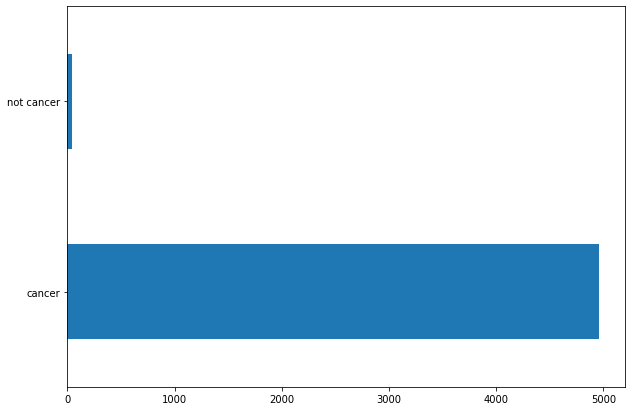

In [20]:
df['Y'].value_counts().plot(kind='barh', figsize = (10,7))

Looks like the dataset is extremely imbalanced. Might have to do do something for it. 

I tried to visualize these values as well.
Figure below shows the boxplots for two of these features.

(0, 250)

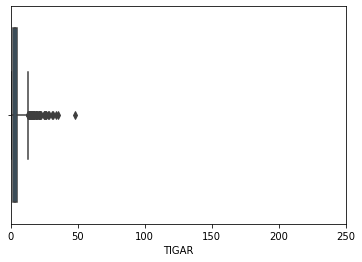

In [21]:
import seaborn as sns
sns.boxplot(df['TIGAR'], whis= 3)
plt.xlim(0, 250)

(0, 250)

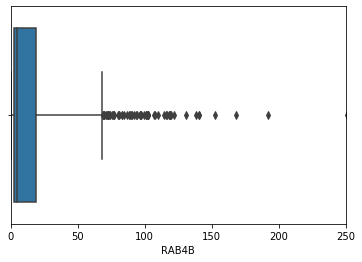

In [22]:
import seaborn as sns
sns.boxplot(df['RAB4B'], whis= 3)
plt.xlim(0, 250)

There are some outliers, but not sure we need to remove them for classifier to improve its robustness or use just as it is since this is Gene's data. 
Also since we are more concerned on the determination of classification, I'd say we can get away with this since it performed satisfactorily.

### Label Encoding the categorical variable Y

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()

df['Y'] = label_encoder.fit_transform(df['Y'])
df['Y'].head()

0    0
1    0
2    0
3    0
4    0
Name: Y, dtype: int64

In [24]:
print(len(label_encoder.classes_))
label_encoder.classes_

2


array(['cancer', 'not cancer'], dtype=object)

In [25]:
labels = df.pop("labels")
Y = df.pop("Y")

In [26]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: Y, dtype: int64

### Converting Y into 1-hot

In [27]:
# Y = keras.utils.to_categorical(Y)
# Y

In [28]:
df.head() # X

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,ZNF708,...,SLCO4C1,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4
0,2.367912,0.698684,3.931116,0.000000,116.288461,13.839265,0.021383,14.722173,5.437620,0.124913,...,0.000000,1.199607,0.101155,1.428458,2.471339,0.042357,44.610061,6.394772,0.281878,0.0
1,26.299800,2.498500,0.255600,14.944300,2.049600,3.262300,0.146400,14.132900,3.323600,0.014800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,5.592506,2.953563,7.065690,0.012499,325.521932,22.144552,0.356845,28.899361,6.717593,1.759132,...,0.030674,2.062158,0.185503,8.414909,2.690346,0.688731,0.260365,9.792451,1.671371,0.0
3,21.554200,1.334700,1.095300,23.476800,8.741300,11.491700,0.945500,32.975700,6.187900,42.428300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,22.820100,2.640900,3.750800,29.774900,7.595200,15.186900,0.482000,19.233800,8.741800,1.025000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Get the subset of FPKM and Gene's data

In [29]:
df.columns.shape, fpkm_df.columns.shape

((19102,), (29688,))

In [30]:
intersect_cols = np.intersect1d(df.columns, fpkm_df.columns)
print(intersect_cols.shape)

(16645,)


In [31]:
df = df[intersect_cols]
print(df.shape)
df.head()

(5000, 16645)


,A1BG,A1CF,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADACL3,AADACL4,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,9.590309,12.479927,0.000000,0.0000,1.620959,0.0000,11.202862,0.812310,0.0000,0.00000,...,3.115799,0.653368,3.123988,0.318739,0.512813,2.479865,0.038790,2.474220,32.734571,0.720153
1,2.025700,0.000000,0.082000,16.1707,0.049500,0.3176,0.000000,1.001800,0.2553,0.21080,...,0.000000,21.073500,0.110300,1.157100,0.246400,0.000000,0.176600,0.096900,0.000000,0.230700
2,0.046677,0.007302,0.384062,0.0000,20.283908,0.0000,12.500055,2.208952,0.0000,0.01484,...,5.733971,1.306286,2.182037,0.608059,2.248505,3.513787,0.363497,2.745613,71.281340,2.437730
3,4.007400,0.149100,0.628500,15.1556,0.347500,1.1154,0.000000,0.693600,0.5979,0.07050,...,0.000000,11.740800,0.654500,1.439300,7.710000,0.664300,5.375500,0.272300,0.000000,3.677500
4,6.315200,0.178500,1.724200,13.5937,0.069300,1.5579,0.000000,0.592200,1.0737,0.12660,...,0.000000,15.540800,2.350500,1.744900,4.988900,0.556700,1.732600,0.461800,0.000000,9.052900


### Train-Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 16645), (1000, 16645), (4000,), (1000,))

Faced MemoryError while standardizing this so doing these steps  
- reset df variable from memory
- save backup for splitted data

In [33]:
# # Variables in memory that's hogging the memories greater than 1MB.
# local_vars = list(locals().items())
# for var, obj in local_vars:
#     size = sys.getsizeof(obj)/1000
#     if size > 1024:
#         print(var, size/1024,"MB")

# # df 2439707.544 KB # Evenif the memory was just 2.4GB, it was giving issues occassionally.
# # labels 1075.379 KB
# # X_train 1951868.152 KB
# # X_test 487967.056 KB
# # y_train 1737.104 KB


In [34]:
# %reset_selective -f "^df$"  # Releasing memory of df variable

### Feature Scaling 

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 
X_test.shape

(1000, 16645)

In [36]:
# filename = "../data/splitted_data_fpkm.npz"
# # filename = "../data/splitted_data_X_train.npz"

In [37]:
# np.savez_compressed(filename, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# print(f"{filename}Data saved..")

Load the splitted variables for next step.
Just Run this below to load them and start experimentation later.

In [38]:
# a = np.load(filename)

In [39]:
# X_train, X_test, y_train, y_test = a["X_train"], a["X_test"], a["y_train"], a["y_test"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 16645), (1000, 16645), (4000,), (1000,))

## Training

In [40]:
irf_utils.run_iRF?

Signature:
irf_utils.run_iRF(
    X_train,
    X_test,
    y_train,
    y_test,
    rf,
    rf_bootstrap=None,
    initial_weights=None,
    K=7,
    B=10,
    random_state_classifier=2018,
    signed=False,
    propn_n_samples=0.2,
    bin_class_type=1,
    M=4,
    max_depth=2,
    noisy_split=False,
    num_splits=2,
    n_estimators_bootstrap=5,
)
Docstring:
Runs the iRF algorithm.


Parameters
----------
X_train : array-like or sparse matrix, shape = [n_samples, n_features]
    Training vector, where n_samples in the number of samples and
    n_features is the number of features.

X_test : array-like or sparse matrix, shape = [n_samples, n_features]
    Test vector, where n_samples in the number of samples and
    n_features is the number of features.

y_train : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) target values for training.

y_test : 1d array-like, or label indicator array / sparse matrix
    Ground truth (correct) target values for 

In [41]:
all_rf_weights, all_K_iter_rf_data, \
    all_rf_bootstrap_output, all_rit_bootstrap_output, \
    stability_score = irf_utils.run_iRF(X_train=X_train,
                                        X_test=X_test,
                                        y_train=y_train,
                                        y_test=y_test,
                                        K=5,                          # number of iteration
                                        rf = RandomForestClassifierWithWeights(n_estimators=20),
                                        B=30,
                                        random_state_classifier=2018, # random seed
                                        propn_n_samples=.2,
                                        bin_class_type=1,
                                        M=20,
                                        max_depth=5,
                                        noisy_split=False,
                                        num_splits=2,
                                        n_estimators_bootstrap=5)

/home/zeus/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/met

In [42]:
print(all_rf_weights['rf_weight5'])

[0. 0. 0. ... 0. 0. 0.]


In [43]:
print(stability_score)

{'7497_10634_15233_15943': 0.03333333333333333, '10634_15233': 0.03333333333333333, '10634': 0.2, '10634_15943': 0.03333333333333333, '11092': 0.06666666666666667, '9388_10634_11092_15233_15943': 0.03333333333333333, '10634_15233_15943': 0.03333333333333333, '10634_11043_15233': 0.03333333333333333, '15233': 0.2, '10634_11092_15943': 0.03333333333333333, '4825_10634_11092': 0.03333333333333333, '7779_11610': 0.03333333333333333, '4825_10634_11092_14378': 0.03333333333333333, '7497_8191_10634_15233_15943': 0.03333333333333333, '10634_11092': 0.03333333333333333, '4825_7497_8191_10634_15233_15943': 0.03333333333333333, '11043': 0.06666666666666667, '2102_5366': 0.03333333333333333, '2102_5366_11043_16231': 0.03333333333333333, '2102_11043_16231': 0.03333333333333333, '2102': 0.1, '5366': 0.06666666666666667, '2102_5366_11043': 0.03333333333333333, '5366_9853': 0.03333333333333333, '2102_11043': 0.03333333333333333, '2974_7368_16321': 0.03333333333333333, '2974_16321': 0.03333333333333333

In [45]:
import json

# Serialize and save similarity score into file:
with open( "stability_score.json", 'w' ) as f:
    json.dump( stability_score,  f)

In [48]:
# Read similarity score
data = json.load( open( "stability_score.json" ) )

### Validation with FPKM

In [ ]:
# fpkm_X_test = fpkm_df[intersect_cols]

In [ ]:
# predicted_labels = np.argmax(model.predict(fpkm_X_test), axis=1)

# test_range = [:10]
# print("Predicted labels: ", predicted_valid_labels[test_range])

# predicts = label_encoder.inverse_transform(predicted_valid_labels[test_range])
# print("FPKM Predictions:\n",predicts)

## Evaluating with Validation set

In [ ]:
# predicted_valid_labels = np.argmax(model.predict(X_test), axis=1)
# valid_labels = np.argmax(y_test, axis=1)

# test_range = [:10]
# print("Predicted labels: ", predicted_valid_labels[test_range])
# print("True labels: ", valid_labels[test_range])

# real = label_encoder.inverse_transform(valid_labels[test_range])
# predicts = label_encoder.inverse_transform(predicted_valid_labels[test_range])
# print("real:preds\n",[real[i]:predicts[i] for i in test_range])

In [ ]:
# # Visualization of Confusion Matrix
# import seaborn as sns

# cm = metrics.confusion_matrix(valid_labels, predicted_valid_labels)
# # print(cm)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plt.figure(figsize=(20,20))
# sns.heatmap(cm_normalized, annot=True, fmt=".4f", linewidths=.5, square = True, cmap = 'summer')
# plt.xlabel('Predicted Values', size=20)
# plt.ylabel('Actual Values', size=20)

# ticks = np.arange(len(set(valid_labels)))
# tick_marks = ['Adrenal', 'Bile', 'Bladder', 'Bone', 'Brain', 'Breast', 'Cervix',
#        'Colon', 'Esophagus', 'Fallopian', 'Head', 'Kidney', 'Leukemia',
#        'Liver', 'Lung', 'Lymph', 'Mediastinum', 'Nervous', 'Ocular',
#        'Ovarian', 'Pancreas', 'Pelvis', 'Peritoneum', 'Pleura',
#        'Prostate', 'Rectum', 'Sarcoma', 'Skin', 'Stomach', 'Testis',
#        'Thymus', 'Thyroid', 'Uterus', 'none']

# plt.xticks(ticks+0.5 ,tick_marks, rotation=90, size=12) #add 0.5 to ticks to position it at center
# plt.yticks(ticks+0.5 ,tick_marks, rotation=0, size=12)
# # all_sample_title = 'Accuracy Score: {:.4f}'.format(93) # hardcoded this from training logs for now :D
# # plt.title(all_sample_title, size = 30)
# plt.show()